Udacity CarND Advanced Lane Finding

1 - Camera Calibration

In [1]:
# Import required libraries
import numpy as np
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
#create object points
objp = np.zeros((6*9, 3), np.float32)
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)
#arrays to store object points and image points
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image space
# create a list of calibration images
calibration_images = glob.glob('./camera_cal/calibration*.jpg')
print("Found {} images.".format(len(calibration_images)))


Found 20 images.


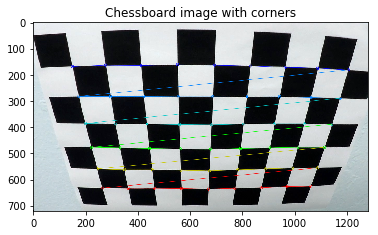

In [3]:
# prepare object points
nx = 9 # The number of inside corners in x
ny = 6 # The number of inside corners in y
# Load chessboard images
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)
# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard image with corners")
    plt.show()

In [4]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners

for idx, fname in enumerate(calibration_images):
    img = cv2.imread(fname)
    #plt.imshow(img)
    #exit()
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # if found add object points, image points
    if ret == True:
        print('Processing', fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)

Processing ./camera_cal/calibration9.jpg
Processing ./camera_cal/calibration10.jpg
Processing ./camera_cal/calibration19.jpg
Processing ./camera_cal/calibration20.jpg
Processing ./camera_cal/calibration13.jpg
Processing ./camera_cal/calibration6.jpg
Processing ./camera_cal/calibration8.jpg
Processing ./camera_cal/calibration7.jpg
Processing ./camera_cal/calibration18.jpg
Processing ./camera_cal/calibration3.jpg
Processing ./camera_cal/calibration16.jpg
Processing ./camera_cal/calibration2.jpg
Processing ./camera_cal/calibration15.jpg
Processing ./camera_cal/calibration12.jpg
Processing ./camera_cal/calibration17.jpg
Processing ./camera_cal/calibration14.jpg
Processing ./camera_cal/calibration11.jpg


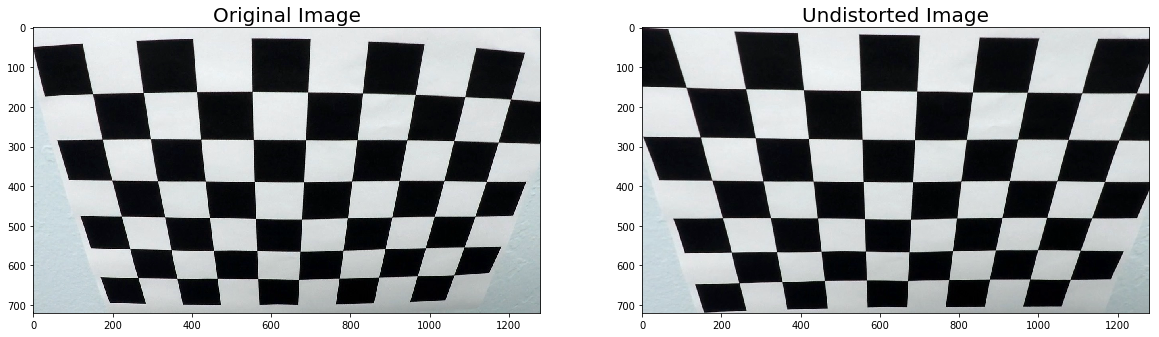

In [5]:
# Test undistortion on an image
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)

dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

2 - Pipeline (test images)

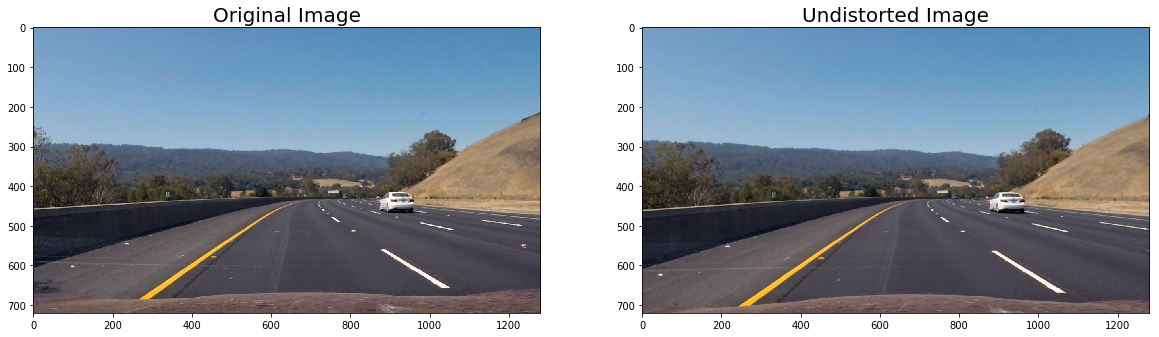

In [6]:
test_image = cv2.imread('./test_images/test3.jpg')
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
undist_image = cv2.undistort(test_image, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_image)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(undist_image)
ax2.set_title('Undistorted Image', fontsize=20)
plt.show()

Binary image computation

In [7]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, ksize, orient='x', thresh_min=0, thresh_max=255):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
def hls_threshold(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def undistort_image(image):
    dst = cv2.undistort(image, mtx, dist, None, mtx)
    return dst


In [8]:
def edge_detection(image):
    
    # Choose a Sobel kernel size
    ksize = 5

    img = cv2.GaussianBlur(image, (ksize, ksize), 0)
    # Convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    # Define sobel kernel size
    ksize = 7
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, ksize, orient='x', thresh_min=10, thresh_max=255)
    grady = abs_sobel_thresh(img, ksize, orient='y', thresh_min=60, thresh_max=255)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(40, 255))
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(.65, 1.05))
    # Combine all the thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    # Threshold color channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors    
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    # Defining vertices for marked area
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1150, imshape[0])
    inner_apex1 = (700,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, right_bottom, inner_right_bottom, inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    # Masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary

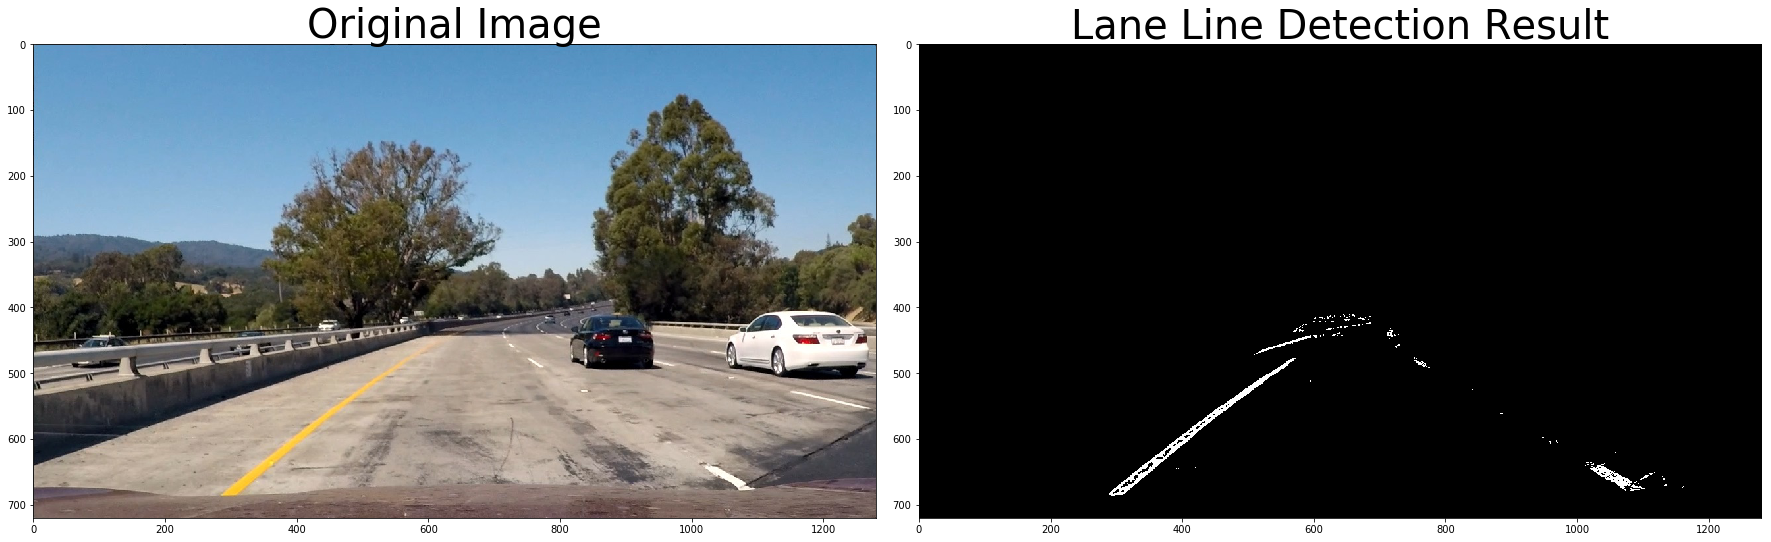

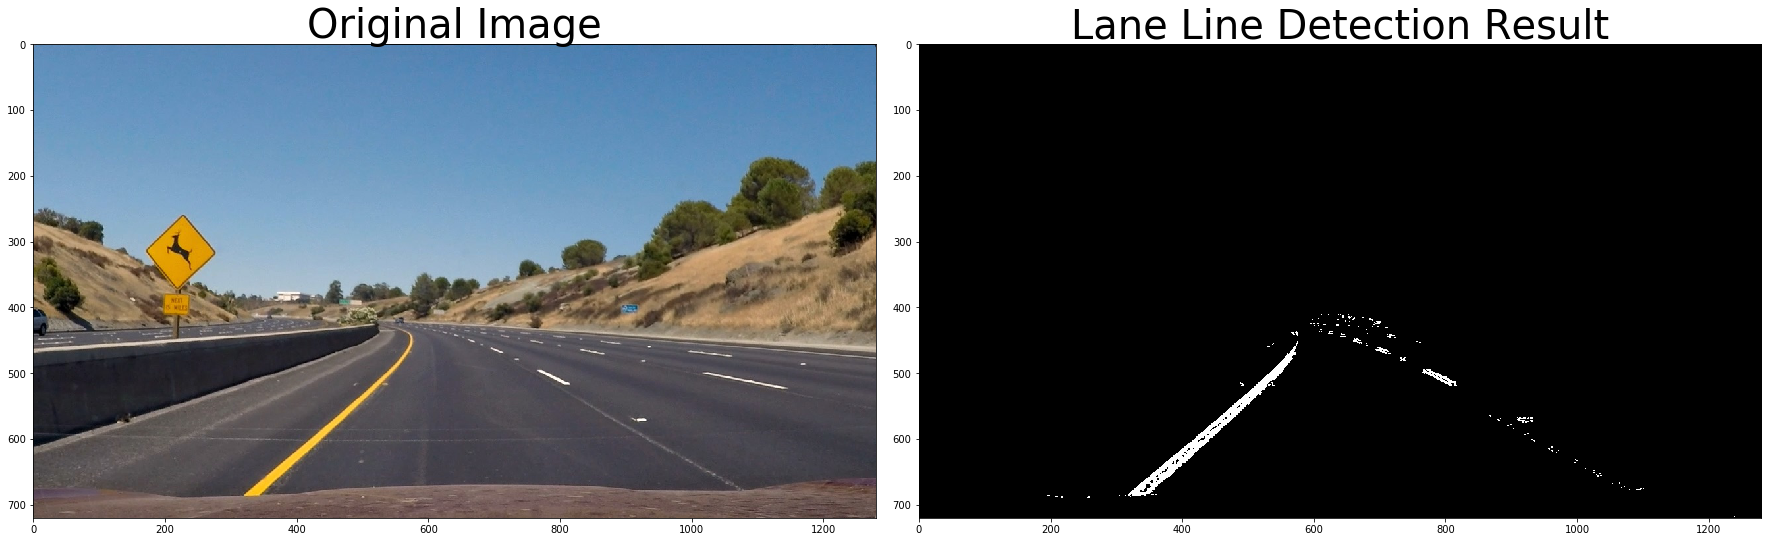

In [9]:
for i in range(1,3):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    result = edge_detection(image)
    
    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original Image', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Lane Line Detection Result', fontsize=40)

   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plt.show()

Perspective Transformation

In [10]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the i
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

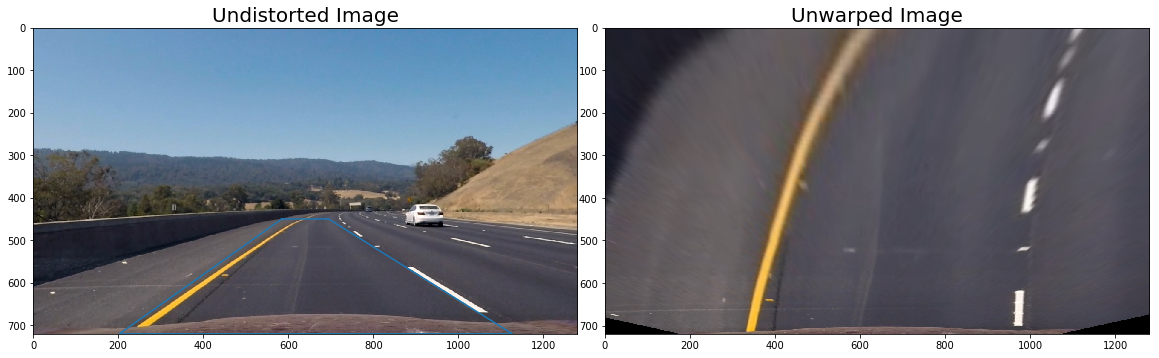

In [11]:
h,w = undist_image.shape[:2]

# define source and destination points for transform
src = np.float32([[585, 450], [203, 720], [1127, 720], [695, 450]])
dst = np.float32([[320, 0], [320, 720], [960,720], [960, 0]])

unwarp_image, M, Minv = unwarp(undist_image, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_image)
x = [src[0][0],src[3][0],src[2][0],src[1][0],src[0][0]]
y = [src[0][1],src[3][1],src[2][1],src[1][1],src[0][1]]
ax1.plot(x, y) # Visulaizing src points on undistorted image(trapezoid lane points)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=20)
ax2.imshow(unwarp_image)
ax2.set_title('Unwarped Image', fontsize=20)
plt.show()

Lane Line Detection and Polynomial Fitting

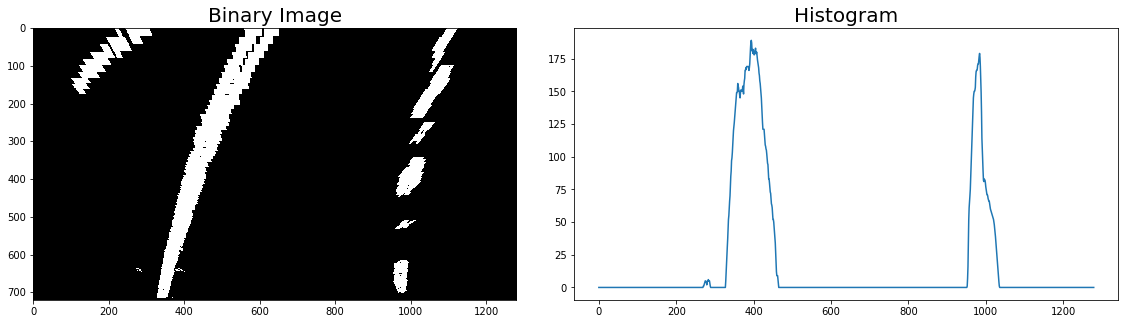

In [12]:
img_edges = edge_detection(undist_image)
unwarp_image, M, Minv = unwarp(img_edges, src, dst)
binary_image = np.zeros_like(unwarp_image)
binary_image [unwarp_image>0] = 1
histogram = np.sum(binary_image[binary_image.shape[0]//2:,:], axis=0)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(binary_image,'gray')
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Binary Image', fontsize=20)
ax2.plot(histogram)
ax2.set_title('Histogram', fontsize=20)
plt.show()

Plot Polynomial

In [13]:
def fit_poly(warped_image):
    
    # Assuming you have created a warped binary image called "binary_warped"
    binary_warped = binary_image
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = list()
    right_lane_inds = list()

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds += good_left_inds.tolist()
        right_lane_inds += good_right_inds.tolist()
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        
    
    return out_img

In [14]:
def get_lanes_window(img):
    """Retrieve lane lines based on a sliding-window-based search."""
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img)) * 255

    # Get histogram of lower half of the image:
    histogram = np.sum(img[img.shape[0] // 2:, :], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window + 1) * window_height
        win_y_high = img.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
        nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
        nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_image.shape[0]-1, binary_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    return left_fitx, right_fitx, ploty, out_img

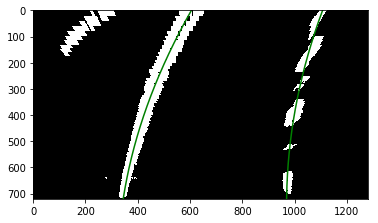

In [15]:
left_fitx, right_fitx, ploty, out_img = get_lanes_window(binary_image)



plt.imshow(out_img)
plt.imshow(binary_image,'gray')
plt.plot(left_fitx, ploty, color='green')
plt.plot(right_fitx, ploty, color='green')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

Compute Radius of Curvature

In [16]:
def find_curvature(yvals, fitx):
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(yvals)
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5)                                  /np.absolute(2*fit_cr[0])
    return curverad

In [17]:
yvals = np.linspace(0, 100, num=left_fitx.shape[0])*7.2  # to cover same y-range as image
left_curverad  = find_curvature(yvals, left_fitx)
right_curverad = find_curvature(yvals, right_fitx)
print(left_curverad,'m')
print(right_curverad,'m')

2128.83255087 m
1992.7535481 m


Plotting on the Road

In [18]:
def draw_poly(binary_warped, undist_image, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    try:
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    except:
        pass
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_image, 1, newwarp, 0.3, 0)
    
    # Put text on an image
    font = cv2.FONT_HERSHEY_SIMPLEX
    curvature  = find_curvature(yvals, left_fitx)
    text = "Radius of Curvature: {} m".format(int(curvature))
    cv2.putText(result,text,(400,100), font, 1,(255,255,255),2)
    
    screen_middel_pixel = undist_image.shape[1]/2

    xm_per_pix = 3.7 / 700
    
    left_lane_pixel = left_fitx[::-1][0]    # x position for left lane
    right_lane_pixel = right_fitx[::-1][0]   # x position for right lane
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel-car_middle_pixel
    meters_off_center = xm_per_pix * screen_off_center
    
    if meters_off_center < 0:
        text = "Vehicle is {:.2f} m left of center".format(-meters_off_center)
    else:
        text = "Vehicle is {:.2f} m right of center".format(meters_off_center)
    cv2.putText(result,text,(400,150), font, 1,(255,255,255),2)
    
    return result

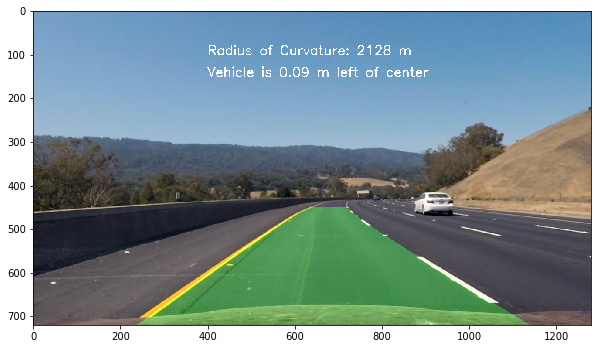

In [19]:
result = draw_poly(binary_image, undist_image, left_fitx, right_fitx, ploty)
plt.figure(figsize=(10,8))
plt.imshow(result)
plt.show()

Pipeline (video)

In [20]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [21]:
def sanity_check(left_lane, right_lane):
    sanity = false
    if (not(left_lane.detected) or not(right_lane.detected)):
        return false
    
    if abs(left_lane.radius_of_curvature - right_lane.radius_of_curvature)<10:
        sanity = true
    
    if abs(left_lane.bestx - right_lane.bestx)>50:
        sanity = true
    
    return sanity
    

In [22]:
def process_frame(frame):
    undist_img = undistort_image(frame)
    edge_binary_image = edge_detection(undist_img)
    
    warped_binary_image, M, Minv = unwarp(edge_binary_image, src, dst)
   
    left_fitx, right_fitx, ploty, poly_image = get_lanes_window(warped_binary_image)
    
    return draw_poly(warped_binary_image, undist_img, left_fitx, right_fitx, ploty)

In [23]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
project_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_frame) #NOTE: this function expects color images!!
%time project_clip.write_videofile(project_output, audio=False)


[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [05:40<00:00,  3.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 23min 10s, sys: 8.16 s, total: 23min 18s
Wall time: 5min 40s
